# **Relatório Técnico: Estudo Exploratório sobre Detecção Automática de Discurso de Ódio - *Stemming***

|Relatório Técnico ID  |2021/08|
|--|--|
| Título |Estudo Exploratório sobre Detecção Automática de Discurso de Ódio - *Stemming*|
| Autoras | Hannah Plath, Paula Dornhofer|
| Data de Criação| 2020 - 08|



#**Descrição do Notebook**

Este notebook contém um estudo exploratório sobre detecção automática de discurso de ódio. Para tal é utilizada a base [OffComBR](https://github.com/eduardofroes/OffComBR).

## Manipulando a base e testando *RSLP* e Snow


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from string import punctuation
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import numpy as np
import re

%load_ext google.colab.data_table

In [ ]:
!git clone https://github.com/eduardofroes/OffComBR.git

Cloning into 'OffComBR'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 0), reused 2 (delta 0), pack-reused 22
Unpacking objects: 100% (25/25), done.


In [ ]:
data_frame = pd.read_csv('./OffComBR/OffComBR.csv', delimiter = ';', encoding = 'utf-8', header = None, names = ['Label','Data'], error_bad_lines = True, warn_bad_lines = True)
data_frame

,Label,Data
0,yes,Votaram no PEZAO Agora tomem no CZAO
1,no,cuidado com a poupanca pessoal Lembram o que a...
2,no,Sabe o que eu acho engracado os nossos governa...
3,no,Podiam retirar dos lucros dos bancos
4,no,CADE O GALVAO PRA NARRAR AGORA FALIIIIUUUUUU...
...,...,...
1028,no,Cruz so tem agilidade mesmo poder de nocaute z...
1029,no,Meus caros amigos enigmaticosNao deveriam comp...
1030,yes,Ele chamava pra atras da escola e sentava nos ...
1031,no,Jhalim Rabei ate fiquei assustado comecei a le...


In [ ]:
yes = len(data_frame[data_frame.Label == 'yes'])
no = len(data_frame[data_frame.Label == 'no'])
print(yes, no)

202 831


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

#Stopwords

unwantedChars = [
    '\'', 
    '\"',
    '/p',
    'ª',
    'º',
    '.',
    '!',
    '?',
    ',',
    ';',
    ':',
    '-',
    '\'',
    '!!'
    ]

palavras = {
    'nao',
    'vai',
    'pra',
    'para',
    'ja',
    'sao',
    'ser',
    'la',
    'ai',
    'ta',
    'so',
    'ne',
    'la',
    'brasil',
    'carne'
}



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
mystopwords = set(list(punctuation) + list(palavras) + list(unwantedChars) + stopwords.words('portuguese'))

In [ ]:
print(mystopwords)

{'sem', 'seremos', 'estiverem', 'pra', 'essas', 'estejamos', 'até', 'depois', 'tinha', 'brasil', 'houvéssemos', 'esta', 'que', '%', 'sejam', 'pelos', 'muito', 'vocês', 'estivera', 'houve', 'hajamos', 'teus', 'teve', 'já', 'tiver', 'hão', 'tu', 'às', 'tive', 'seriam', 'nosso', 'temos', 'estivéssemos', 'houveram', '(', 'estivermos', 'serei', 'serão', 'esse', '~', 'mesmo', '$', 'ele', 'eram', 'houvesse', "'", 'ao', 'meus', 'estas', 'fossem', 'estamos', 'estavam', '!!', 'estivessem', 'houverão', '+', 'seja', 'tiveram', 'este', 'nossos', 'fôramos', 'será', 'num', 'aos', 'teriam', 'te', 'fui', 'estive', 'º', 'para', '/p', '.', 'la', 'com', 'tenham', 'somos', 'lhes', 'teria', 'houverá', 'isso', 'entre', 'quando', 'for', 'há', 'esteve', 'foi', 'dos', '#', 'são', '_', '=', 'seríamos', 'os', 'tém', '"', 'uma', 'minhas', 'esses', 'tenhamos', 'teremos', 'pelas', 'no', ')', 'se', 'à', '?', 'mas', 'nós', 'lhe', 'nossas', 'as', 'estávamos', 'suas', 'houvera', 'tem', 'tivera', '[', 'tinham', '@', '&',

In [ ]:
#Tokenizing

tokenized_data_frame = data_frame['Data'].apply(word_tokenize)

In [ ]:
data = pd.DataFrame(tokenized_data_frame)
data

,Data
0,"[Votaram, no, PEZAO, Agora, tomem, no, CZAO]"
1,"[cuidado, com, a, poupanca, pessoal, Lembram, ..."
2,"[Sabe, o, que, eu, acho, engracado, os, nossos..."
3,"[Podiam, retirar, dos, lucros, dos, bancos]"
4,"[CADE, O, GALVAO, PRA, NARRAR, AGORA, FALIIIIU..."
...,...
1028,"[Cruz, so, tem, agilidade, mesmo, poder, de, n..."
1029,"[Meus, caros, amigos, enigmaticosNao, deveriam..."
1030,"[Ele, chamava, pra, atras, da, escola, e, sent..."
1031,"[Jhalim, Rabei, ate, fiquei, assustado, comece..."


**Usando o RSLPStemmer**

In [ ]:
from nltk.stem import RSLPStemmer
nltk.download('rslp')
def stemming_and_stopwords (text):
  texto_filtrado = []
  text = nltk.word_tokenize(text)
  stemmer = RSLPStemmer()
  for word in text:
    if word.lower() not in mystopwords:
      texto_filtrado.append(stemmer.stem(word.lower()))

  return(texto_filtrado)

In [ ]:
data_stemming = data_frame[:]['Data'].apply(stemming_and_stopwords)

In [ ]:
%load_ext google.colab.data_table
df = pd.DataFrame(data_stemming) 
df

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,Data
0,"[vot, peza, agor, tom, cza]"
1,"[cuid, poupanc, pessoal, lembr, acontec, epoc,..."
2,"[sab, ach, engrac, govern, pens, cort, regal, ..."
3,"[pod, retir, lucr, banc]"
4,"[cad, galva, narr, agor, faliiiiuuuuuuu, falii..."
...,...
1028,"[cruz, agil, pod, nocaut, zer, cody, vei, prep..."
1029,"[car, amig, enigmaticosna, dev, comparal, tyso..."
1030,"[cham, atr, escol, sent, garot, kkkk]"
1031,"[jhalim, rab, ate, fiq, assust, comec, ler, co..."


**Usando Snowball Portuguese**

In [ ]:
from nltk.stem.snowball import SnowballStemmer
def stemming_snowball_and_stopwords (text):
  texto_filtrado = []
  text = nltk.word_tokenize(text)
  portugueseStemmer = SnowballStemmer('portuguese')

  for word in text:
    if word.lower() not in mystopwords:
      texto_filtrado.append(portugueseStemmer.stem(word.lower()))

  return(texto_filtrado)

In [ ]:
data_stemming_snow = data_frame[:]['Data'].apply(stemming_snowball_and_stopwords)

In [ ]:
df_snow = pd.DataFrame(data_stemming_snow) 
df_snow

,Data
0,"[vot, peza, agor, tom, cza]"
1,"[cuid, poupanc, pessoal, lembr, acontec, epoc,..."
2,"[sab, acho, engrac, govern, pens, cort, regal,..."
3,"[pod, retir, lucr, banc]"
4,"[cad, galva, narr, agor, faliiiiuuuuuuu, falii..."
...,...
1028,"[cruz, agil, pod, nocaut, zer, cody, vei, prep..."
1029,"[car, amig, enigmaticosna, dev, comparal, tyso..."
1030,"[cham, atras, escol, sent, garot, kkkk]"
1031,"[jhalim, rab, ate, fiqu, assust, comec, ler, c..."


In [ ]:
def plotarNuvem(data_tokenized):
  allWordsinRows = data_tokenized[:][:]
  allWords = []

  for words in allWordsinRows:
    allWords.extend(words)

  # The FreqDist class is used to encode “frequency distributions”, which count
  # the number of times that each outcome of an experiment occurs
  # FreqDist devolve um dicionário onde cada key é uma palavra distinta (?)

  frequencia = nltk.FreqDist(allWords)
  sorted(frequencia, key = frequencia.__getitem__, reverse = True)

  wordcloud = WordCloud().generate_from_frequencies(frequencia)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

  return allWordsinRows, frequencia

def plotFrenquencies(fr):
  fr.plot(20,cumulative=False)

## RSLPStemmer: testando modelos de ML

### Busca dos melhores parâmetros

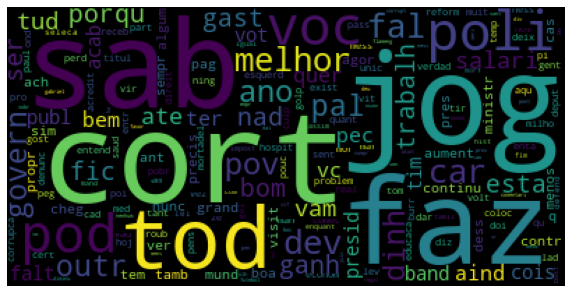

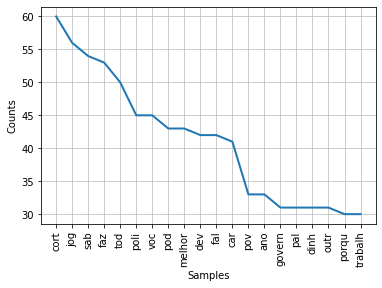

In [ ]:
allWords_RSLP, frequencies_RSLP= plotarNuvem(data_stemming )
plotFrenquencies(frequencies_RSLP)

In [ ]:
#Construindo o vocabulário para o BoW

def extractNumericalBoW(frase, total_features_map):
  words = set(frase)
  word_features = {}

  for w in total_features_map:
    count = 0

    for word in words:
      if word == w:
        count = count+1

    word_features[w] = count

  return word_features

In [ ]:
#lista com todas as palavras distintas 
total_features_RSLP = list(frequencies_RSLP.keys())[:]

#lista das classificações
Y_data_RSLP = [label for label in data_frame[:]['Label']]
X_data_RSLP = []

for i in range(len(allWords_RSLP)):
   X_data_RSLP.append((extractNumericalBoW(allWords_RSLP[i], total_features_RSLP), Y_data_RSLP[i]))

# X_data é do tipo [({'votaram': 1, 'a' : 0, ....}, 'yes'), ({'votaram':0, 'a':1, ...}, 'no')]

In [ ]:
def DictToArray(X_data):

  X_data_array = []
  Y_data_array = []

  for X in X_data:
    feature = []
    for feat in X[0].values():
      feature.append(feat)

    X_data_array.append(feature)
    Y_data_array.append(1 if X[1] == 'yes' else 0)

  X_data_np = np.array(X_data_array)
  Y_data_np = np.array(Y_data_array, dtype = int)

  return X_data_np, Y_data_array

In [ ]:
X_data_np_RSLP, Y_data_np_RSLP = DictToArray(X_data_RSLP)

In [ ]:
kfold = 5

parametros = {
    'kernel': ['linear','poly','rbf'],
    'gamma': ['auto', 'scale'],
    'C': [0.1, 0.3, 0.45, 0.5, 0.6, 0.7, 0.8, 1],
    'class_weight' : ['balanced']
}

scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

cv = KFold(n_splits = kfold, shuffle = True, random_state = 42)

grid_RSLP = GridSearchCV(
    estimator = SVC(),
    param_grid = parametros,
    cv = cv,
    scoring = scoring,
    refit =  'f1',
    verbose = 3
)

grid_RSLP.fit(X_data_np_RSLP, Y_data_np_RSLP)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.787, average_precision=0.552, f1=0.511, precision=0.561, recall=0.469, roc_auc=0.793, total=   3.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.821, average_precision=0.456, f1=0.565, precision=0.511, recall=0.632, roc_auc=0.770, total=   3.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.758, average_precision=0.478, f1=0.468, precision=0.367, recall=0.647, roc_auc=0.789, total=   3.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.835, average_precision=0.571, f1=0.564, precision=0.550, recall=0.579, roc_auc=0.791, total=   3.8s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.825, average_precision=0.604, f1=0.561, precision=0.590, recall=0.535, roc_auc=0.816, total=   3.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.237, average_precision=0.561, f1=0.383, precision=0.237, recall=1.000, roc_auc=0.797, total=   4.6s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   4.6s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.406, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.798, total=   4.6s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.390, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.769, total=   4.5s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.398, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.770, total=   4.6s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.237, average_precision=0.552, f1=0.383, precision=0.237, recall=1.000, roc_auc=0.779, total=   4.7s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   4.7s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.464, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.785, total=   4.7s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.214, average_precision=0.546, f1=0.319, precision=0.190, recall=1.000, roc_auc=0.796, total=   4.6s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.509, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   4.6s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.1, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   4.6s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   4.6s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.589, average_precision=0.375, f1=0.406, precision=0.309, recall=0.592, roc_auc=0.648, total=   4.5s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.575, average_precision=0.318, f1=0.371, precision=0.255, recall=0.684, roc_auc=0.657, total=   4.5s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.609, average_precision=0.319, f1=0.362, precision=0.247, recall=0.676, roc_auc=0.670, total=   4.6s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.763, average_precision=0.561, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.797, total=   4.6s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   4.6s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.406, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.798, total=   4.5s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.390, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.769, total=   4.5s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.398, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.770, total=   4.6s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.763, average_precision=0.552, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.779, total=   4.6s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   4.7s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.464, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.785, total=   4.7s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.546, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.796, total=   4.6s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.509, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   4.6s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.3, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.483, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   4.6s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.490, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   4.6s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.725, average_precision=0.423, f1=0.513, precision=0.441, recall=0.612, roc_auc=0.692, total=   4.3s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.652, average_precision=0.382, f1=0.410, precision=0.298, recall=0.658, roc_auc=0.687, total=   4.4s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.657, average_precision=0.398, f1=0.372, precision=0.266, recall=0.618, roc_auc=0.699, total=   4.4s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   4.7s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=poly ..........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.406, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.798, total=   4.7s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=poly ..........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.390, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.769, total=   4.6s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=poly ..........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.398, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.770, total=   4.6s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   4.8s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.464, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.785, total=   4.7s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.546, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.796, total=   4.7s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.509, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   4.7s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=linear .......
[CV]  C=0.45, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.506, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   4.6s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=poly .........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.499, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.804, total=   4.6s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.739, average_precision=0.454, f1=0.500, precision=0.458, recall=0.551, roc_auc=0.718, total=   4.3s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.696, average_precision=0.411, f1=0.400, precision=0.313, recall=0.553, roc_auc=0.711, total=   4.3s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.734, average_precision=0.438, f1=0.421, precision=0.328, recall=0.588, roc_auc=0.714, total=   4.3s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   4.5s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.406, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.798, total=   4.6s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.390, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.769, total=   4.7s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.398, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.770, total=   4.5s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=ba

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   4.7s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.464, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.785, total=   4.7s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.546, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.796, total=   4.6s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.509, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   4.7s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.5, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.544, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.783, total=   4.5s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.743, total=   4.6s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   4.6s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.505, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   4.6s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.507, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.807, total=   4.6s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.739, average_precision=0.459, f1=0.481, precision=0.455, recall=0.510, roc_auc=0.723, total=   4.3s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.710, average_precision=0.425, f1=0.423, precision=0.333, recall=0.579, roc_auc=0.716, total=   4.4s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.744, average_precision=0.460, f1=0.430, precision=0.339, recall=0.588, roc_auc=0.718, total=   4.4s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.763, average_precision=0.561, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.797, total=   4.5s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   4.5s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.406, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.798, total=   4.5s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.390, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.769, total=   4.6s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.398, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.770, total=   4.5s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.763, average_precision=0.552, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.779, total=   4.6s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   4.6s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.464, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.785, total=   4.6s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.546, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.796, total=   4.6s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.509, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   4.6s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.6, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.542, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   4.5s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.448, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.742, total=   4.6s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.777, total=   4.5s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.517, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   4.6s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.516, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.808, total=   4.7s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.773, average_precision=0.471, f1=0.515, precision=0.521, recall=0.510, roc_auc=0.735, total=   4.3s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.749, average_precision=0.450, f1=0.447, precision=0.375, recall=0.553, roc_auc=0.727, total=   4.4s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.754, average_precision=0.487, f1=0.440, precision=0.351, recall=0.588, roc_auc=0.726, total=   4.4s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.763, average_precision=0.561, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.797, total=   4.5s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   4.6s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.406, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.798, total=   4.5s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.390, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.769, total=   4.5s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.791, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   4.5s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.763, average_precision=0.552, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.779, total=   4.6s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   4.6s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.464, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.785, total=   4.7s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.546, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   4.6s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.791, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.791, total=   4.6s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=linear, accuracy=0.792, average_precision=0.595, f1=0.456, precision=0.600, recall=0.367, roc_auc=0.821, total=   3.6s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=linear, accuracy=0.821, average_precision=0.484, f1=0.431, precision=0.519, recall=0.368, roc_auc=0.754, total=   3.6s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=linear, accuracy=0.816, average_precision=0.487, f1=0.472, precision=0.447, recall=0.500, roc_auc=0.761, total=   3.6s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.536, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   4.5s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.457, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.740, total=   4.5s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   4.5s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.527, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   4.5s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.531, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.809, total=   4.5s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.787, average_precision=0.484, f1=0.500, precision=0.564, recall=0.449, roc_auc=0.750, total=   4.2s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.749, average_precision=0.463, f1=0.409, precision=0.360, recall=0.474, roc_auc=0.735, total=   4.4s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.792, average_precision=0.512, f1=0.456, precision=0.400, recall=0.529, roc_auc=0.730, total=   4.4s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   4.6s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.406, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.798, total=   4.6s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.390, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.769, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.398, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.770, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.237, average_precision=0.552, f1=0.383, precision=0.237, recall=1.000, roc_auc=0.779, total=   4.6s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   4.6s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.464, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.785, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.214, average_precision=0.546, f1=0.319, precision=0.190, recall=1.000, roc_auc=0.796, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.509, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   4.6s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.8, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.551, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.739, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.544, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.536, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.810, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.773, average_precision=0.503, f1=0.405, precision=0.533, recall=0.327, roc_auc=0.760, total=   4.1s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.797, average_precision=0.482, f1=0.447, precision=0.447, recall=0.447, roc_auc=0.744, total=   4.2s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.831, average_precision=0.516, f1=0.493, precision=0.486, recall=0.500, roc_auc=0.734, total=   4.4s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   4.6s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=poly .............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.406, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.798, total=   4.6s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=poly .............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.390, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.769, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=poly .............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.398, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.770, total=   4.7s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, ga

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.464, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.785, total=   4.6s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.546, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.796, total=   4.6s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.509, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   4.5s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=linear ..........
[CV]  C=1, class_weight=balanced, gamma=

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.575, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.786, total=   4.5s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.464, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.741, total=   4.5s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.774, total=   4.6s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.563, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.804, total=   4.5s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.522, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.806, total=   4.5s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.778, average_precision=0.522, f1=0.361, precision=0.565, recall=0.265, roc_auc=0.776, total=   4.5s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.821, average_precision=0.506, f1=0.448, precision=0.517, recall=0.395, roc_auc=0.746, total=   4.5s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.831, average_precision=0.515, f1=0.444, precision=0.483, recall=0.412, roc_auc=0.741, total=   4.4s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, g

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 17.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.3, 0.45, 0.5, 0.6, 0.7, 0.8, 1],
                         'class_weight': ['balanced'],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'average_precision', 'f1', 'precision',
                      'recall', 'roc_auc'],
             verbose=3)

In [ ]:
print(grid_RSLP.best_score_)
print(grid_RSLP.best_params_)

0.5337960547411386
{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}


In [ ]:
parametros_forest = {
    'n_estimators': [100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [80, 90, 100, 110],
    'min_samples_split'  : [2, 5, 8, 10],
    'min_samples_leaf' : [1, 3, 5]
}

grid_forest_RSLP = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = parametros_forest,
    scoring = scoring,
    refit = 'f1',
    cv = 5,
    verbose = 3
)

grid_forest_RSLP.fit(X_data_np_RSLP, Y_data_np_RSLP)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.338, f1=0.200, precision=0.556, recall=0.122, roc_auc=0.636, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.831, average_precision=0.515, f1=0.255, precision=1.000, recall=0.146, roc_auc=0.720, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.836, average_precision=0.493, f1=0.370, precision=0.714, recall=0.250, roc_auc=0.731, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.854, average_precision=0.502, f1=0.444, precision=0.857, recall=0.300, roc_auc=0.720, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.373, f1=0.167, precision=0.500, recall=0.100, roc_auc=0.677, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=200, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.499, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.812, average_precision=0.434, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.711, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.816, average_precision=0.469, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.744, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   2.1s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.816, average_precision=0.414, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.694, total=   2.0s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.816, average_precision=0.469, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.725, total=   2.1s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.527, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.797, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.812, average_precision=0.411, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.692, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.816, average_precision=0.461, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.743, total=   1.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   2.0s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.816, average_precision=0.467, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.728, total=   2.1s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.825, average_precision=0.506, f1=0.182, precision=1.000, recall=0.100, roc_auc=0.735, total=   2.1s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.455, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.764, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.461, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.399, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.628, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.408, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.458, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.403, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.273, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.525, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.811, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.407, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.782, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.404, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.669, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.400, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.272, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.503, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   1.0s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.461, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.301, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.643, total=   1.0s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.793, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.301, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.771, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.300, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.482, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.435, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.391, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.664, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.279, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.505, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.450, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.283, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.614, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.513, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.810, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.402, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.474, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.448, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.374, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.516, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.791, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.404, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.675, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.289, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.394, f1=0.231, precision=0.545, recall=0.146, roc_auc=0.662, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.514, f1=0.280, precision=0.778, recall=0.171, roc_auc=0.730, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accu

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.490, f1=0.140, precision=1.000, recall=0.075, roc_auc=0.728, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.825, average_precision=0.496, f1=0.182, precision=1.000, recall=0.100, roc_auc=0.713, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.502, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   2.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.816, average_precision=0.429, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.711, total=   2.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.816, average_precision=0.469, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.732, total=   2.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.505, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.804, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.399, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.666, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.310, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.644, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.415, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   1.0s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.464, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.725, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.365, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.678, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.277, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.621, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.504, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.813, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.450, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.375, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.282, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.537, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.818, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.435, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.385, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.488, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   1.0s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.444, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   1.0s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.288, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.493, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.792, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.409, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.680, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.414, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.285, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.490, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   0.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   0.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.444, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.266, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.471, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.779, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.399, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.408, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.311, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.656, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.510, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.279, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.621, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.465, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.728, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.293, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.645, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.517, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.803, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.0s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.0s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.277, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   1.0s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.521, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.807, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.382, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.289, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.376, f1=0.226, precision=0.500, recall=0.146, roc_auc=0.681, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.500, f1=0.240, precision=0.667, recall=0.146, roc_auc=0.716, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.449, f1=0.048, precision=0.500, recall=0.025, roc_auc=0.726, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.830, average_precision=0.513, f1=0.222, precision=1.000, recall=0.125, roc_auc=0.745, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.504, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   2.1s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.812, average_precision=0.423, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.691, total=   2.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.816, average_precision=0.477, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.729, total=   2.1s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.498, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.403, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.412, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.667, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.280, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.607, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.545, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.803, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   1.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.444, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.287, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.399, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.281, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.628, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.541, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.373, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.364, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.287, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.620, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.797, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.435, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.274, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.621, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.536, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.816, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.390, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.313, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.651, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.521, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.785, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.256, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.602, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.488, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.785, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.386, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   1.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.404, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.506, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   1.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   1.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.306, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.526, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.808, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.256, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.547, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.807, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.392, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.679, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.284, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.614, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.527, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.803, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.381, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.407, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.294, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.374, f1=0.240, precision=0.667, recall=0.146, roc_auc=0.662, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.836, average_precision=0.493, f1=0.292, precision=1.000, recall=0.171, roc_auc=0.708, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=10

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.816, average_precision=0.467, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.718, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.820, average_precision=0.512, f1=0.178, precision=0.800, recall=0.100, roc_auc=0.741, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimat

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.525, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.400, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.351, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.255, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.587, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.510, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.815, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.401, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.285, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.628, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.527, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.813, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.402, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.258, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.523, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.797, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.397, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.320, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.793, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.293, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.510, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.814, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.409, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.306, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.538, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.812, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.412, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.671, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.388, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.282, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.608, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.504, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.386, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.308, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.480, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.792, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.409, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.306, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.485, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.266, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.460, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.778, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   1.1s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.1s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.403, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   1.1s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.266, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.620, total=   1.1s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.554, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.393, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.288, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   1.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.392, f1=0.240, precision=0.667, recall=0.146, roc_auc=0.672, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.500, f1=0.245, precision=0.750, recall=0.146, roc_auc=0.723, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_e

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.394, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.260, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.611, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.526, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.808, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.303, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.656, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.783, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.407, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.485, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.800, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.407, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.401, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.457, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.503, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.804, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   1.0s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.278, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.626, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.494, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.451, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.786, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.493, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.741, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.300, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.461, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.289, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.496, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.803, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.414, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.408, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.407, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.539, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.822, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.399, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.643, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.457, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.729, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.466, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.738, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.285, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.488, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.445, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.446, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.281, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.612, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.404, f1=0.250, precision=0.857, recall=0.146, roc_auc=0.690, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.480, f1=0.250, precision=0.857, recall=0.146, roc_auc=0.722, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.474, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.780, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.445, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.721, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.726, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.279, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.627, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.496, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   1.0s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.380, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   1.0s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.397, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.679, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.288, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.627, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.505, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.791, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   1.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.284, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.771, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.387, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.387, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.262, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.620, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.780, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   1.0s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.286, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.568, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.826, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   1.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.456, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.327, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.514, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.786, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   1.0s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.623, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.478, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.792, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.467, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.725, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.308, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.506, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.414, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.446, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.721, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.297, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   0.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.460, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.783, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.460, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.729, total=   1.0s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.310, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.483, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.793, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.388, f1=0.240, precision=0.667, recall=0.146, roc_auc=0.674, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.512, f1=0.245, precision=0.750, recall=0.146, roc_auc=0.723, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_spli

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.474, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.764, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.297, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.485, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.283, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   1.0s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.471, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.721, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.312, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.511, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.297, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.529, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.678, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.301, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.643, total=   1.0s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.490, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.805, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.448, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.781, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.451, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.391, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.286, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.512, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.457, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.282, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.474, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.785, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   1.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.294, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.627, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.466, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.785, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.450, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.393, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.290, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.501, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.800, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.305, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.486, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.290, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.406, f1=0.245, precision=0.750, recall=0.146, roc_auc=0.684, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.548, f1=0.217, precision=1.000, recall=0.122, roc_auc=0.737, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_spl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.485, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.792, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.445, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.544, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.811, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.445, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.283, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.517, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.809, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.409, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.453, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.273, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.502, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.809, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   1.1s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.540, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.816, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.703, total=   1.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.279, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   1.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.480, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.782, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.286, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.627, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.463, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.291, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.435, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   1.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.478, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.783, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.412, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.623, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.502, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.412, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.286, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.622, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.518, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 38.5min finished


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.296, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   1.4s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              warm_start=False),
             iid='deprecated', n_jobs=None,
  

In [ ]:
print(grid_forest_RSLP.best_score_)
print(grid_forest_RSLP.best_params_)

0.3192218641842702
{'criterion': 'entropy', 'max_depth': 110, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
def TrainClassifierWithScore (kfold, X_data_np, Y_data_np, classifier_type):

  scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

  cv = KFold(n_splits = kfold, shuffle = True, random_state = 42)

  # C: default = 1, the strength of the regularization is inversely proportional to C
  # gamma: {'scale', 'auto'} ou float
  # 'auto' = 1/n_features
  # 'scale' = 1/(n_features*X.var())
  # class_weight: sets C -> class_weight[i]*C
  # 'balanced' = n_samples/(n_classes*np.bincount(y))
  #np.bincount -> Count number of occurrences of each value in array of non-negative ints

  if classifier_type == 'svm_poly':
    classifier = SVC(kernel = 'poly', C = 0.45, probability = True, gamma = 'auto', class_weight = 'balanced')
      
  elif classifier_type == 'svm_rbf':
    classifier = SVC(kernel = 'rbf', C = 0.45, probability = True, gamma = 'auto', class_weight = 'balanced')
      
  elif classifier_type == 'svm_linear':
    classifier = SVC(kernel = 'linear', C = 0.45, probability = True, gamma = 'auto', class_weight = 'balanced')

  elif classifier_type == 'svm_linear_grid':
    classifier = SVC(kernel = 'linear', C = 0.1, probability = True, gamma = 'auto', class_weight = 'balanced')

  elif classifier_type == 'naive_gaussiano':
    classifier = GaussianNB()

  elif classifier_type == 'naive_bernoulli':
    classifier = BernoulliNB(binarize = None)

  elif classifier_type == 'random_forest_Grid':
    classifier = RandomForestClassifier(n_estimators = 100, criterion='gini', max_depth = 110, min_samples_leaf=1, min_samples_split=2 )

  elif classifier_type == 'random_forest':
        classifier = RandomForestClassifier(n_estimators=100)

  results = cross_validate(estimator = classifier, X = X_data_np, y = Y_data_np, cv = cv, scoring = scoring, return_train_score = True)

  return results

In [ ]:
kfold = 5

#training SVM  Poly
score_svm__poly_RSLP = TrainClassifierWithScore(kfold, X_data_np_RSLP, Y_data_np_RSLP, 'svm_poly')

#training SVM linear model
score_svm_linear_RSLP = TrainClassifierWithScore(kfold, X_data_np_RSLP, Y_data_np_RSLP, 'svm_linear')

#training SVM linear model GridSearch
score_svm_linear_RSLP_GridSearch = TrainClassifierWithScore(kfold, X_data_np_RSLP, Y_data_np_RSLP, 'svm_linear_grid')

#training Svm rbf model
score_svm_rbf_RSLP = TrainClassifierWithScore(kfold, X_data_np_RSLP, Y_data_np_RSLP, 'svm_rbf')

#training Naive Bayes Gaussian Classifier
score_naive_gauss_RSLP = TrainClassifierWithScore(kfold, X_data_np_RSLP, Y_data_np_RSLP, 'naive_gaussiano')

#training Naive Bayes Bernoulli Classifier
score_naive_bernoulli_RSLP = TrainClassifierWithScore(kfold, X_data_np_RSLP, Y_data_np_RSLP, 'naive_bernoulli')

#training Random Forest model
score_random_forest_RSLP = TrainClassifierWithScore(kfold, X_data_np_RSLP, Y_data_np_RSLP, 'random_forest' )

#training Random Forest model GridSearch
score_random_forest_RSLP_GridSearch = TrainClassifierWithScore(kfold, X_data_np_RSLP, Y_data_np_RSLP, 'random_forest_Grid' )


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

In [ ]:
def printScoreTable(scores, kfold, classifier_type):
  print("\nClassifier:%s" % classifier_type)
  print("K:\tAcc.:\tPre:\tRec.:\tF1-S.:")
  mean_acc = 0
  mean_pre = 0
  mean_rec = 0
  mean_f1 = 0
  for i in range(kfold):
    mean_acc += (scores['test_accuracy'])[i]
    mean_pre += (scores['test_precision'])[i]
    mean_rec += (scores['test_recall'])[i]
    mean_f1 += (scores['test_f1'])[i]
    print("%i\t%.4f\t%.4f\t%.4f\t%.4f\t" % (i+1, scores['test_accuracy'][i], scores['test_precision'][i], scores['test_recall'][i], scores['test_f1'][i]))
  
  print("Mean\t%.4f\t%.4f\t%.4f\t%.4f\t" % (mean_acc/kfold, mean_pre/kfold, mean_rec/kfold, mean_f1/kfold))

In [ ]:
#Teste SVM linear
printScoreTable(score_svm_linear_RSLP, kfold, 'RSLP: svm_linear')

#Teste SVM Poly
printScoreTable(score_svm__poly_RSLP, kfold, 'RSLP: svm_poly')

#Teste SVM RBF
printScoreTable(score_svm_rbf_RSLP, kfold, 'RSLP: svm_rbf')

#Teste SVM Linear GridSearch para melhor f1 score
printScoreTable(score_svm_linear_RSLP_GridSearch, kfold, 'RSLP: svm_linear_GridSearch')

#Teste Random Forest
printScoreTable(score_random_forest_RSLP, kfold, 'RSLP: random_forest')

#Teste Random Forest GridSearch para melhor f1 score
printScoreTable(score_random_forest_RSLP_GridSearch, kfold, 'RSLP: random_forest_GridSearch')

#Naive Bayes Gaussiano
printScoreTable(score_naive_gauss_RSLP, kfold, 'RSLP: naive_bayes_gaussiano')

#Naive Bayes Bernoulli
printScoreTable(score_naive_bernoulli_RSLP, kfold, 'RSLP: naive_bayes_bernoulli')


Classifier:RSLP: svm_linear
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.8068	0.6452	0.4082	0.5000	
2	0.8164	0.5000	0.3947	0.4412	
3	0.8164	0.4524	0.5588	0.5000	
4	0.8447	0.6071	0.4474	0.5152	
5	0.8495	0.7727	0.3953	0.5231	
Mean	0.8268	0.5955	0.4409	0.4959	

Classifier:RSLP: svm_poly
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.2367	0.2367	1.0000	0.3828	
2	0.8164	0.0000	0.0000	0.0000	
3	0.1643	0.1643	1.0000	0.2822	
4	0.1845	0.1845	1.0000	0.3115	
5	0.2087	0.2087	1.0000	0.3454	
Mean	0.3221	0.1588	0.8000	0.2644	

Classifier:RSLP: svm_rbf
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.2367	0.2367	1.0000	0.3828	
2	0.8164	0.0000	0.0000	0.0000	
3	0.1643	0.1643	1.0000	0.2822	
4	0.1845	0.1845	1.0000	0.3115	
5	0.2087	0.2087	1.0000	0.3454	
Mean	0.3221	0.1588	0.8000	0.2644	

Classifier:RSLP: svm_linear_GridSearch
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.7874	0.5610	0.4694	0.5111	
2	0.8213	0.5106	0.6316	0.5647	
3	0.7585	0.3667	0.6471	0.4681	
4	0.8350	0.5500	0.5789	0.5641	
5	0.8252	0.5897	0.5349	0.5610	
Mean	0.8055	0.5156	0.5724	0.5338	

Classifier:RS

### Fazendo o fit e as matrizes de confusão dos melhores modelos

In [ ]:
y_data_RSLP = pd.Series(Y_data_np_RSLP)
y_data_RSLP

from sklearn.model_selection import train_test_split
# 0,75 -> treino
x_train_RSLP, x_test_RSLP, y_train_RSLP, y_test_RSLP = train_test_split(X_data_np_RSLP, y_data_RSLP, random_state = 42)

#x_train, y_train 774
#x_test, y_test 259

In [ ]:
model_svm_linear_GridSearch_RSLP = SVC(kernel = 'linear', C = 0.1, probability = True, gamma = 'auto', class_weight = 'balanced')
model_svm_linear_GridSearch_RSLP.fit(x_train_RSLP,y_train_RSLP)

model_naive_RSLP = GaussianNB()
model_naive_RSLP.fit(x_train_RSLP, y_train_RSLP)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import joblib

joblib.dump(model_svm_linear_GridSearch_RSLP, "SVM_linear_GridSearch_model_RSLP.pkl")
joblib.dump(model_naive_RSLP, "Naive_model_RSLP.plk")

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

# get the folder id where you want to save your file
file1 = drive.CreateFile()
file1.SetContentFile("SVM_linear_GridSearch_model_RSLP.pkl")
file1.Upload()
file1 = drive.CreateFile()
file1.SetContentFile("Naive_model_RSLP.plk")
file1.Upload()

In [ ]:
import joblib
svm_linear_model_RSLP = joblib.load('SVM_linear_GridSearch_model_RSLP.pkl')
naive_model_RSLP = joblib.load("Naive_model_RSLP.plk")

In [ ]:
from sklearn.metrics import confusion_matrix
y_predict_svm_RSLP = svm_linear_model_RSLP.predict(x_test_RSLP)
confusion_matrix(y_test_RSLP, y_predict_svm_RSLP)

array([[177,  21],
       [ 30,  31]])

In [ ]:
y_predict_naive_RSLP = naive_model_RSLP.predict(x_test_RSLP)
confusion_matrix(y_test_RSLP, y_predict_naive_RSLP)

array([[173,  25],
       [ 33,  28]])

### Quais as frases identificadas erroneamente? Naive Bayes

In [ ]:
index_RSLP = y_test_RSLP.keys()
data_RSLP = y_test_RSLP.array

In [ ]:
data_frame.Data[1]

'cuidado com a poupanca pessoal Lembram o que aconteceu na epoca do Collor ne'

In [ ]:
true_positives_naive_RSLP = []
true_negatives_naive_RSLP = []
false_positives_naive_RSLP = []
false_negatives_naive_RSLP = []

for i in range (len(data_RSLP)):
  if data_RSLP[i] == y_predict_naive_RSLP[i]:
    if data_RSLP[i] == 1:
      true_positives_naive_RSLP.append(data_frame.Data[index_RSLP[i]])
    else:
      true_negatives_naive_RSLP.append(data_frame.Data[index_RSLP[i]])
  if data_RSLP[i] != y_predict_naive_RSLP[i]:
    if y_predict_naive_RSLP[i] == 1:
      false_positives_naive_RSLP.append(data_frame.Data[index_RSLP[i]])
    if y_predict_naive_RSLP[i] == 0:
      false_negatives_naive_RSLP.append(data_frame.Data[index_RSLP[i]])

In [ ]:
tp_naive_RSLP = pd.DataFrame(true_positives_naive_RSLP)
fp_naive_RSLP = pd.DataFrame(false_positives_naive_RSLP)
fn_naive_RSLP = pd.DataFrame(false_negatives_naive_RSLP)
tn_naive_RSLP = pd.DataFrame(true_negatives_naive_RSLP)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
tp_naive_RSLP.to_csv('tp_naive_RSLP.csv')
fn_naive_RSLP.to_csv('fn_naive_RSLP.csv')
fp_naive_RSLP.to_csv('fp_naive_RSLP.csv')
tn_naive_RSLP.to_csv('tn_naive_RSLP.csv')
!cp fn_naive_RSLP.csv "drive/My Drive/"
!cp fp_naive_RSLP.csv "drive/My Drive/"
!cp tp_naive_RSLP.csv "drive/My Drive/"
!cp tn_naive_RSLP.csv "drive/My Drive/"

### Quais as frases identificadas erroneamente? SVM linear

In [ ]:
true_positives_svm_RSLP = []
true_negatives_svm_RSLP = []
false_positives_svm_RSLP = []
false_negatives_svm_RSLP = []

for i in range (len(data_RSLP)):
  if data_RSLP[i] == y_predict_svm_RSLP[i]:
    if data_RSLP[i] == 1:
      true_positives_svm_RSLP.append(data_frame.Data[index_RSLP[i]])
    else:
      true_negatives_svm_RSLP.append(data_frame.Data[index_RSLP[i]])
  if data_RSLP[i] != y_predict_svm_RSLP[i]:
    if y_predict_svm_RSLP[i] == 1:
      false_positives_svm_RSLP.append(data_frame.Data[index_RSLP[i]])
    if y_predict_svm_RSLP[i] == 0:
      false_negatives_svm_RSLP.append(data_frame.Data[index_RSLP[i]])

In [ ]:
tp_svm_RSLP = pd.DataFrame(true_positives_svm_RSLP)
fp_svm_RSLP = pd.DataFrame(false_positives_svm_RSLP)
fn_svm_RSLP = pd.DataFrame(false_negatives_svm_RSLP)
tn_svm_RSLP = pd.DataFrame(true_negatives_svm_RSLP)

In [ ]:
tp_svm_RSLP.to_csv('tp_svm_RSLP.csv')
fn_svm_RSLP.to_csv('fn_svm_RSLP.csv')
fp_svm_RSLP.to_csv('fp_svm_RSLP.csv')
tn_svm_RSLP.to_csv('tn_svm_RSLP.csv')
!cp fn_svm_RSLP.csv "drive/My Drive/"
!cp fp_svm_RSLP.csv "drive/My Drive/"
!cp tp_svm_RSLP.csv "drive/My Drive/"
!cp tn_svm_RSLP.csv "drive/My Drive/"

##Snowball

###Busca dos melhores parâmetros

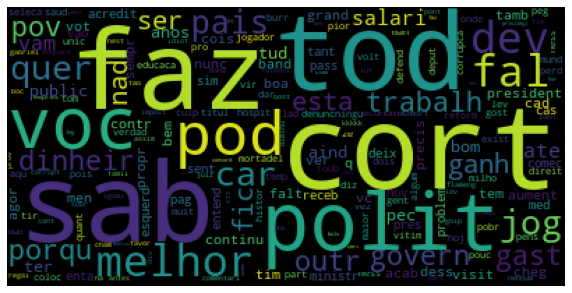

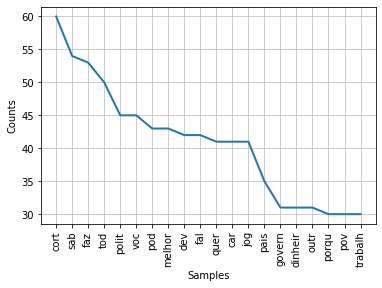

In [ ]:
allWords_snow, frequencies_snow= plotarNuvem(data_stemming_snow )
plotFrenquencies(frequencies_snow)

In [ ]:
#lista com todas as palavras distintas 
total_features_snow = list(frequencies_snow.keys())[:]

#lista das classificações
Y_data_snow = [label for label in data_frame[:]['Label']]
X_data_snow = []

for i in range(len(allWords_snow)):
   X_data_snow.append((extractNumericalBoW(allWords_snow[i], total_features_snow), Y_data_snow[i]))

# X_data é do tipo [({'votaram': 1, 'a' : 0, ....}, 'yes'), ({'votaram':0, 'a':1, ...}, 'no')]

In [ ]:
X_data_np_snow, Y_data_np_snow = DictToArray(X_data_snow)

In [ ]:
kfold = 5

parametros = {
    'kernel': ['linear','poly','rbf'],
    'gamma': ['auto', 'scale'],
    'C': [0.1, 0.3, 0.45, 0.5, 0.6, 0.7, 0.8, 1],
    'class_weight' : ['balanced']
}

scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

cv = KFold(n_splits = kfold, shuffle = True, random_state = 42)

grid_snow = GridSearchCV(
    estimator = SVC(),
    param_grid = parametros,
    cv = cv,
    scoring = scoring,
    refit =  'f1',
    verbose = 3
)

grid_snow.fit(X_data_np_snow, Y_data_np_snow)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.792, average_precision=0.534, f1=0.517, precision=0.575, recall=0.469, roc_auc=0.779, total=   4.2s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.807, average_precision=0.495, f1=0.535, precision=0.479, recall=0.605, roc_auc=0.781, total=   4.1s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.797, average_precision=0.497, f1=0.523, precision=0.426, recall=0.676, roc_auc=0.802, total=   4.2s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.820, average_precision=0.540, f1=0.532, precision=0.512, recall=0.553, roc_auc=0.786, total=   4.1s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.820, average_precision=0.597, f1=0.554, precision=0.575, recall=0.535, roc_auc=0.826, total=   4.1s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.237, average_precision=0.562, f1=0.383, precision=0.237, recall=1.000, roc_auc=0.801, total=   4.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   4.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.410, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.793, total=   4.8s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.375, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.759, total=   4.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.396, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.772, total=   4.8s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.237, average_precision=0.523, f1=0.383, precision=0.237, recall=1.000, roc_auc=0.777, total=   4.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   4.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.468, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.801, total=   4.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.228, average_precision=0.512, f1=0.323, precision=0.193, recall=1.000, roc_auc=0.788, total=   4.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.501, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.794, total=   4.9s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.1, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   4.8s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.486, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   4.8s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.472, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   4.8s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.594, average_precision=0.375, f1=0.417, precision=0.316, recall=0.612, roc_auc=0.643, total=   4.8s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.585, average_precision=0.321, f1=0.386, precision=0.265, recall=0.711, roc_auc=0.660, total=   4.8s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.609, average_precision=0.313, f1=0.362, precision=0.247, recall=0.676, roc_auc=0.669, total=   4.8s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.763, average_precision=0.562, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   5.0s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   4.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.410, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.793, total=   4.8s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.375, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.759, total=   4.8s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.396, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.772, total=   4.8s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.763, average_precision=0.523, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.777, total=   4.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   4.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.468, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.801, total=   4.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.512, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.788, total=   4.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.501, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.794, total=   4.9s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.3, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.482, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   4.9s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.486, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   5.0s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.710, average_precision=0.417, f1=0.500, precision=0.423, recall=0.612, roc_auc=0.685, total=   4.6s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.638, average_precision=0.392, f1=0.400, precision=0.287, recall=0.658, roc_auc=0.697, total=   4.9s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.643, average_precision=0.382, f1=0.373, precision=0.262, recall=0.647, roc_auc=0.700, total=   4.8s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   4.8s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=poly ..........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.410, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.793, total=   4.8s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=poly ..........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.375, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.759, total=   4.7s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=poly ..........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.396, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.772, total=   4.8s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   5.0s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.468, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.801, total=   4.9s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.512, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.788, total=   4.9s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.501, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.794, total=   4.9s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=linear .......
[CV]  C=0.45, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   4.9s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=poly .........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.490, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.804, total=   4.8s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.720, average_precision=0.449, f1=0.473, precision=0.426, recall=0.531, roc_auc=0.709, total=   4.5s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.710, average_precision=0.428, f1=0.423, precision=0.333, recall=0.579, roc_auc=0.718, total=   4.7s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.744, average_precision=0.425, f1=0.418, precision=0.333, recall=0.559, roc_auc=0.717, total=   4.7s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   4.8s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.410, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.793, total=   4.9s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.375, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.759, total=   4.8s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.396, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.772, total=   4.9s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=ba

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   5.0s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.468, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.801, total=   5.1s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.512, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.788, total=   5.1s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.501, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.794, total=   4.9s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.5, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.543, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.780, total=   4.8s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.450, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.747, total=   4.8s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.786, total=   4.8s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.496, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   4.8s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.496, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.806, total=   4.8s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.744, average_precision=0.453, f1=0.495, precision=0.464, recall=0.531, roc_auc=0.715, total=   4.5s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.739, average_precision=0.442, f1=0.449, precision=0.367, recall=0.579, roc_auc=0.724, total=   4.6s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.754, average_precision=0.444, f1=0.427, precision=0.345, recall=0.559, roc_auc=0.721, total=   4.6s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.763, average_precision=0.562, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   5.0s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   5.0s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.410, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.793, total=   4.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.375, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.759, total=   4.8s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.396, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.772, total=   4.8s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.763, average_precision=0.523, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.777, total=   4.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   4.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.468, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.801, total=   4.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.512, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.788, total=   4.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.501, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.794, total=   4.9s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.6, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.536, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.779, total=   4.8s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.745, total=   4.8s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   4.7s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.498, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.800, total=   4.8s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.506, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.807, total=   4.7s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.787, average_precision=0.467, f1=0.542, precision=0.553, recall=0.531, roc_auc=0.727, total=   4.4s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.773, average_precision=0.456, f1=0.472, precision=0.412, recall=0.553, roc_auc=0.735, total=   4.7s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.768, average_precision=0.486, f1=0.429, precision=0.360, recall=0.529, roc_auc=0.728, total=   4.6s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.763, average_precision=0.562, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   4.8s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   4.8s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.410, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.793, total=   4.8s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.375, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.759, total=   4.8s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.791, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.772, total=   4.8s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.763, average_precision=0.523, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.777, total=   4.9s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   4.9s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.468, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.801, total=   4.9s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.512, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   4.9s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.791, average_precision=0.501, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   4.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=linear, accuracy=0.812, average_precision=0.608, f1=0.494, precision=0.679, recall=0.388, roc_auc=0.823, total=   3.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=linear, accuracy=0.841, average_precision=0.530, f1=0.459, precision=0.609, recall=0.368, roc_auc=0.771, total=   3.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=linear, accuracy=0.831, average_precision=0.487, f1=0.478, precision=0.485, recall=0.471, roc_auc=0.772, total=   4.0s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.537, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.781, total=   4.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.463, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.744, total=   5.1s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   5.0s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   4.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.514, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.811, total=   4.8s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.783, average_precision=0.481, f1=0.494, precision=0.550, recall=0.449, roc_auc=0.738, total=   4.6s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.778, average_precision=0.480, f1=0.452, precision=0.413, recall=0.500, roc_auc=0.744, total=   4.7s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.792, average_precision=0.499, f1=0.427, precision=0.390, recall=0.471, roc_auc=0.731, total=   4.7s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   4.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.410, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.793, total=   4.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.375, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.759, total=   4.8s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.396, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.772, total=   4.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.237, average_precision=0.523, f1=0.383, precision=0.237, recall=1.000, roc_auc=0.777, total=   4.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   4.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.468, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.801, total=   4.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.228, average_precision=0.512, f1=0.323, precision=0.193, recall=1.000, roc_auc=0.788, total=   4.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.501, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.794, total=   5.1s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.8, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.543, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.783, total=   4.8s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.468, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.743, total=   4.8s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.782, total=   4.8s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.532, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.803, total=   4.8s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.523, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.812, total=   4.8s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.783, average_precision=0.485, f1=0.430, precision=0.567, recall=0.347, roc_auc=0.748, total=   4.5s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.807, average_precision=0.501, f1=0.459, precision=0.472, recall=0.447, roc_auc=0.752, total=   4.6s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.816, average_precision=0.502, f1=0.457, precision=0.444, recall=0.471, roc_auc=0.733, total=   4.7s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=poly .............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.410, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.793, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=poly .............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.375, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.759, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=poly .............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.396, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.772, total=   4.9s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, ga

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.776, total=   4.9s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.468, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.801, total=   4.9s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.512, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.788, total=   4.9s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.501, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.794, total=   4.9s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=linear ..........
[CV]  C=1, class_weight=balanced, gamma=

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.563, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.744, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.782, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.533, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.803, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.519, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.809, total=   4.8s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.783, average_precision=0.515, f1=0.384, precision=0.583, recall=0.286, roc_auc=0.766, total=   4.6s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.841, average_precision=0.522, f1=0.492, precision=0.593, recall=0.421, roc_auc=0.758, total=   4.6s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.836, average_precision=0.521, f1=0.469, precision=0.500, recall=0.441, roc_auc=0.741, total=   4.6s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, g

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 18.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.3, 0.45, 0.5, 0.6, 0.7, 0.8, 1],
                         'class_weight': ['balanced'],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'average_precision', 'f1', 'precision',
                      'recall', 'roc_auc'],
             verbose=3)

In [ ]:
print(grid_snow.best_score_)
print(grid_snow.best_params_)

0.5320654726663815
{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}


In [ ]:
parametros_forest = {
    'n_estimators': [100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [80, 90, 100, 110],
    'min_samples_split'  : [2, 5, 8, 10],
    'min_samples_leaf' : [1, 3, 5]
}

grid_forest_snow = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = parametros_forest,
    scoring = scoring,
    refit = 'f1',
    cv = 5,
    verbose = 3
)

grid_forest_snow.fit(X_data_np_snow, Y_data_np_snow)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.387, f1=0.208, precision=0.714, recall=0.122, roc_auc=0.677, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.831, average_precision=0.514, f1=0.255, precision=1.000, recall=0.146, roc_auc=0.707, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.498, f1=0.308, precision=0.667, recall=0.200, roc_auc=0.699, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.845, average_precision=0.527, f1=0.385, precision=0.833, recall=0.250, roc_auc=0.721, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.811, average_precision=0.413, f1=0.170, precision=0.571, recall=0.100, roc_auc=0.716, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=200, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.811, average_precision=0.476, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.713, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.801, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   2.0s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.816, average_precision=0.396, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.695, total=   2.1s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.816, average_precision=0.461, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.721, total=   2.1s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.408, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.816, average_precision=0.437, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.728, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.820, average_precision=0.484, f1=0.178, precision=0.800, recall=0.100, roc_auc=0.724, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.506, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.773, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.816, average_precision=0.497, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.747, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.816, average_precision=0.467, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.711, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.816, average_precision=0.412, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.708, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.816, average_precision=0.461, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.718, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.462, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.793, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.386, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.664, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.331, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.542, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.816, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.408, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.394, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.671, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.389, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.703, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.403, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.315, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.519, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.460, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.274, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.613, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.484, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.785, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   1.0s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.616, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.487, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.401, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.404, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.385, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.645, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.483, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.780, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.288, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.482, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.797, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.388, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.312, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.628, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.458, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.383, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.643, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.292, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.648, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.518, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.810, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.388, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.321, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.487, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.791, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.391, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.403, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.308, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.427, f1=0.245, precision=0.750, recall=0.146, roc_auc=0.672, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.509, f1=0.217, precision=1.000, recall=0.122, roc_auc=0.709, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accu

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.816, average_precision=0.470, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.726, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.825, average_precision=0.474, f1=0.182, precision=1.000, recall=0.100, roc_auc=0.715, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.518, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.371, f1=0.048, precision=1.000, recall=0.024, roc_auc=0.650, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.417, f1=0.048, precision=0.500, recall=0.025, roc_auc=0.710, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.519, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.792, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.812, average_precision=0.402, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.700, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.816, average_precision=0.449, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.725, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.534, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   2.1s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.821, average_precision=0.407, f1=0.178, precision=1.000, recall=0.098, roc_auc=0.705, total=   2.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.812, average_precision=0.462, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.736, total=   2.1s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.501, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.812, average_precision=0.445, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.723, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.816, average_precision=0.495, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.719, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.512, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.409, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.387, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.511, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.815, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.283, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.625, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.485, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.313, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.407, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   0.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.308, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.481, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.780, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.380, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.453, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.409, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.515, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.808, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.618, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.757, total=   0.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.394, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.285, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.635, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.762, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.397, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.318, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.653, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.494, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.806, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.370, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.296, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.522, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   0.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.382, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.675, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.409, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.451, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.288, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.620, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.466, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   1.0s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.408, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   0.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.315, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.662, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.459, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.786, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   1.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.395, f1=0.245, precision=0.750, recall=0.146, roc_auc=0.643, total=   1.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.526, f1=0.245, precision=0.750, recall=0.146, roc_auc=0.727, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.503, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.731, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.402, f1=0.048, precision=0.500, recall=0.025, roc_auc=0.713, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.506, f1=0.048, precision=1.000, recall=0.024, roc_auc=0.786, total=   2.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.502, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.816, average_precision=0.423, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.706, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.816, average_precision=0.432, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.728, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.510, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   2.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.812, average_precision=0.421, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.706, total=   2.1s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.812, average_precision=0.466, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.729, total=   2.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.412, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.812, average_precision=0.444, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.723, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.825, average_precision=0.463, f1=0.217, precision=0.833, recall=0.125, roc_auc=0.719, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimat

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.514, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.377, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.397, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.528, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.383, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.329, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.390, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.340, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.678, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.809, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.364, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.385, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.466, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.388, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.384, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.810, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.393, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.392, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.494, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.321, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.475, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.769, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.373, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.346, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.322, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.488, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.397, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.382, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.482, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   1.1s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.389, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.321, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.660, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.513, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.373, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.352, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.397, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.279, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.586, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.490, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.779, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.404, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.412, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.389, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.400, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.669, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.322, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.414, f1=0.245, precision=0.750, recall=0.146, roc_auc=0.664, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.831, average_precision=0.537, f1=0.286, precision=0.875, recall=0.171, roc_auc=0.723, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=10

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.502, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   2.1s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.812, average_precision=0.391, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.694, total=   2.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.816, average_precision=0.474, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.715, total=   2.1s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.514, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.780, total=   1.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.816, average_precision=0.411, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.706, total=   1.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.816, average_precision=0.455, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.734, total=   1.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.501, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.778, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.812, average_precision=0.406, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.678, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.816, average_precision=0.489, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.751, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.529, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   2.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.812, average_precision=0.411, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.702, total=   2.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.816, average_precision=0.449, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.715, total=   2.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimat

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.522, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.786, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.414, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.297, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.666, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.401, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.625, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.483, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.793, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.381, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.400, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.505, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.401, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.653, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.780, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.370, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.403, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.307, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.512, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.385, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.678, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.329, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.656, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.549, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.806, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.379, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.367, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.322, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.485, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.744, total=   0.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.382, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.381, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.276, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.618, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.490, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.805, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.377, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.412, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.301, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.627, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.471, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.786, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.389, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.308, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.516, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.781, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.387, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.407, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.272, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.622, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.494, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.793, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.377, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.459, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.281, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.474, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.773, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.4s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   1.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.286, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.635, total=   1.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.425, f1=0.217, precision=1.000, recall=0.122, roc_auc=0.681, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.831, average_precision=0.504, f1=0.255, precision=1.000, recall=0.146, roc_auc=0.717, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_e

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.527, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   1.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.812, average_precision=0.431, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.721, total=   1.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.816, average_precision=0.468, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.745, total=   1.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.529, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.404, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.453, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.721, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.399, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.300, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.772, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.414, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.293, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   1.1s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.409, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.721, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.518, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.806, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.388, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.675, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.389, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.283, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.619, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.486, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.792, total=   0.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.373, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.307, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.524, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.793, total=   1.1s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.412, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   1.1s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.308, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.653, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.482, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.759, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.736, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.444, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.718, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.461, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.286, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.635, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.476, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.782, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.457, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.703, total=   1.1s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.304, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.478, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.786, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.394, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.669, total=   0.4s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.535, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.803, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.446, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.726, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.309, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.651, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.487, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.777, total=   1.1s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.388, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   1.1s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.319, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   1.1s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.430, f1=0.208, precision=0.714, recall=0.122, roc_auc=0.682, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.524, f1=0.208, precision=0.714, recall=0.122, roc_auc=0.728, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.504, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.800, total=   2.0s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.812, average_precision=0.430, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.719, total=   2.0s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.812, average_precision=0.459, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.733, total=   2.0s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.507, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.812, average_precision=0.428, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.716, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.816, average_precision=0.467, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.744, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.517, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   0.7s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.816, average_precision=0.406, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.705, total=   0.7s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.816, average_precision=0.483, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.739, total=   0.7s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.491, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.816, average_precision=0.423, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.714, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.816, average_precision=0.467, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.737, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.515, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.796, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.816, average_precision=0.420, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.713, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.816, average_precision=0.455, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.743, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.451, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.774, total=   0.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.401, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.282, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.623, total=   0.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.519, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   0.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   0.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.448, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.328, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.653, total=   0.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.525, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.804, total=   1.1s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.307, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.659, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.463, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.777, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.737, total=   0.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.645, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.390, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.343, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.498, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.805, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.404, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.703, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.303, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.472, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.769, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.324, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.550, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.296, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.511, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.391, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.448, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.322, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.743, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.414, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.703, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.291, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.607, total=   0.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.481, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.785, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.317, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.453, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.394, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.311, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.410, f1=0.163, precision=0.500, recall=0.098, roc_auc=0.687, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.831, average_precision=0.548, f1=0.255, precision=1.000, recall=0.146, roc_auc=0.722, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_spli

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.524, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   0.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.423, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.715, total=   0.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.462, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.734, total=   0.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_spli

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.522, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   2.0s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.816, average_precision=0.427, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.716, total=   2.0s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.816, average_precision=0.479, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.732, total=   2.0s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_spli

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.491, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.774, total=   0.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.816, average_precision=0.407, f1=0.136, precision=1.000, recall=0.073, roc_auc=0.696, total=   0.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.816, average_precision=0.455, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.729, total=   0.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_spli

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.463, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.779, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.393, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.470, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.733, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.703, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.290, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.505, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.307, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.644, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.480, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.791, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.308, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.792, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.333, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.505, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.450, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.763, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.399, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.675, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.383, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.290, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.614, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.474, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.797, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.730, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.317, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.656, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.456, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.324, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.805, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.479, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.782, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.415, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.320, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.656, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.498, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   1.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.412, f1=0.245, precision=0.750, recall=0.146, roc_auc=0.660, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.517, f1=0.213, precision=0.833, recall=0.122, roc_auc=0.713, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_spl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   0.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.467, f1=0.095, precision=1.000, recall=0.050, roc_auc=0.740, total=   0.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.811, average_precision=0.471, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.720, total=   0.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_spli

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.779, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.725, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.680, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.615, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.477, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   0.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.458, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.741, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.319, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.481, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.793, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.389, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.644, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.478, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.797, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.381, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.322, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.483, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.783, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.404, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.318, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.644, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.499, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.726, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.451, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.718, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.317, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.515, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.291, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.663, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.485, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.792, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.415, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.469, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.733, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.315, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.511, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.811, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.435, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.389, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.307, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.643, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.445, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.805, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.391, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.303, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.481, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.784, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.405, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.418, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   1.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 37.9min finished


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.645, total=   1.4s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              warm_start=False),
             iid='deprecated', n_jobs=None,
  

In [ ]:
print(grid_forest_snow.best_score_)
print(grid_forest_snow.best_params_)

0.2904366435569443
{'criterion': 'gini', 'max_depth': 110, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
def TrainClassifierWithScoreSnow (kfold, X_data_np, Y_data_np, classifier_type):

  scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

  cv = KFold(n_splits = kfold, shuffle = True, random_state = 42)

  # C: default = 1, the strength of the regularization is inversely proportional to C
  # gamma: {'scale', 'auto'} ou float
  # 'auto' = 1/n_features
  # 'scale' = 1/(n_features*X.var())
  # class_weight: sets C -> class_weight[i]*C
  # 'balanced' = n_samples/(n_classes*np.bincount(y))
  #np.bincount -> Count number of occurrences of each value in array of non-negative ints

  if classifier_type == 'svm_poly':
    classifier = SVC(kernel = 'poly', C = 0.45, probability = True, gamma = 'auto', class_weight = 'balanced')
      
  elif classifier_type == 'svm_rbf':
    classifier = SVC(kernel = 'rbf', C = 0.45, probability = True, gamma = 'auto', class_weight = 'balanced')
      
  elif classifier_type == 'svm_linear':
    classifier = SVC(kernel = 'linear', C = 0.45, probability = True, gamma = 'auto', class_weight = 'balanced')

  elif classifier_type == 'svm_linear_grid':
    classifier = SVC(kernel = 'linear', C = 0.1, probability = True, gamma = 'auto', class_weight = 'balanced')

  elif classifier_type == 'naive_gaussiano':
    classifier = GaussianNB()

  elif classifier_type == 'naive_bernoulli':
    classifier = BernoulliNB(binarize = None)

  elif classifier_type == 'random_forest_Grid':
    classifier = RandomForestClassifier(n_estimators = 200, criterion='gini', max_depth = 110, min_samples_leaf=1, min_samples_split=2 )

  elif classifier_type == 'random_forest':
        classifier = RandomForestClassifier(n_estimators=100)

  results = cross_validate(estimator = classifier, X = X_data_np, y = Y_data_np, cv = cv, scoring = scoring, return_train_score = True)

  return results

In [ ]:
kfold = 5

#training SVM  Poly
score_svm__poly_snow = TrainClassifierWithScoreSnow(kfold, X_data_np_snow, Y_data_np_snow, 'svm_poly')

#training SVM linear model
score_svm_linear_snow = TrainClassifierWithScoreSnow(kfold, X_data_np_snow, Y_data_np_snow, 'svm_linear')

#training Svm rbf model
score_svm_rbf_snow = TrainClassifierWithScoreSnow(kfold, X_data_np_snow, Y_data_np_snow, 'svm_rbf')

#training Svm linear model GridSearch
score_svm_linear_snow_GridSearch = TrainClassifierWithScoreSnow(kfold, X_data_np_snow, Y_data_np_snow, 'svm_linear_grid')

#training Naive Bayes Gaussian Classifier
score_naive_gauss_snow = TrainClassifierWithScoreSnow(kfold, X_data_np_snow, Y_data_np_snow, 'naive_gaussiano')

#training Naive Bayes Bernoulli Classifier
score_naive_bernoulli_snow = TrainClassifierWithScoreSnow(kfold, X_data_np_snow, Y_data_np_snow, 'naive_bernoulli')

#training Random Forest model
score_random_forest_snow = TrainClassifierWithScoreSnow(kfold, X_data_np_snow, Y_data_np_snow, 'random_forest' )

#training Random Forest model
score_random_forest_snow_GridSearch = TrainClassifierWithScoreSnow(kfold, X_data_np_snow, Y_data_np_snow, 'random_forest_Grid' )

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

In [ ]:
#Teste SVM linear
printScoreTable(score_svm_linear_snow, kfold, 'snow: svm_linear')

#Teste SVM Poly
printScoreTable(score_svm__poly_snow, kfold, 'snow: svm_poly')

#Teste SVM RBF
printScoreTable(score_svm_rbf_snow, kfold, 'snow: svm_rbf')

#Teste SVM RBF GridSearch para melhor f1 score
printScoreTable(score_svm_linear_snow_GridSearch, kfold, 'snow: svm_linear_GridSearch')

#Teste Random Forest
printScoreTable(score_random_forest_snow, kfold, 'snow: random_forest')

#Teste Random Forest GridSearch para melhor f1 score
printScoreTable(score_random_forest_snow_GridSearch, kfold, 'snow: random_forest_GridSearch')

#Naive Bayes Gaussiano
printScoreTable(score_naive_gauss_snow, kfold, 'snow: naive_bayes_gaussiano')

#Naive Bayes Bernoulli
printScoreTable(score_naive_bernoulli_snow, kfold, 'snow: naive_bayes_bernoulli')


Classifier:snow: svm_linear
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.8116	0.6786	0.3878	0.4935	
2	0.8357	0.5769	0.3947	0.4688	
3	0.8261	0.4706	0.4706	0.4706	
4	0.8544	0.6667	0.4211	0.5161	
5	0.8350	0.6800	0.3953	0.5000	
Mean	0.8326	0.6145	0.4139	0.4898	

Classifier:snow: svm_poly
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.2367	0.2367	1.0000	0.3828	
2	0.8164	0.0000	0.0000	0.0000	
3	0.1643	0.1643	1.0000	0.2822	
4	0.1845	0.1845	1.0000	0.3115	
5	0.2087	0.2087	1.0000	0.3454	
Mean	0.3221	0.1588	0.8000	0.2644	

Classifier:snow: svm_rbf
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.2367	0.2367	1.0000	0.3828	
2	0.8164	0.0000	0.0000	0.0000	
3	0.1643	0.1643	1.0000	0.2822	
4	0.1845	0.1845	1.0000	0.3115	
5	0.2087	0.2087	1.0000	0.3454	
Mean	0.3221	0.1588	0.8000	0.2644	

Classifier:snow: svm_linear_GridSearch
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.7923	0.5750	0.4694	0.5169	
2	0.8068	0.4792	0.6053	0.5349	
3	0.7971	0.4259	0.6765	0.5227	
4	0.8204	0.5122	0.5526	0.5316	
5	0.8204	0.5750	0.5349	0.5542	
Mean	0.8074	0.5135	0.5677	0.5321	

Classifier:sn

### Fazendo o fit e as matrizes de confusão dos melhores modelos

In [ ]:
#pd.Series ela numera o dado
# h = ['a', 'b', 'c']
# index  = [100, 101, 102]
# pd.Series(h, index=index)
# 100  'a'
# 101  'b'
# 102  'c'
y_data_snow = pd.Series(Y_data_np_snow)
#y_data_snow

In [ ]:
from sklearn.model_selection import train_test_split
# 0,75 -> treino
x_train_snow, x_test_snow, y_train_snow, y_test_snow = train_test_split(X_data_np_snow, y_data_snow, random_state = 42)

#x_train, y_train 774
#x_test, y_test 259

In [ ]:
classifier_snow = SVC(kernel = 'linear', C = 0.1, probability = True, gamma = 'auto', class_weight = 'balanced')
classifier_snow.fit(x_train_snow,y_train_snow)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
classifier_snow_naive = GaussianNB()
classifier_snow_naive.fit(x_train_snow,y_train_snow)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import joblib

joblib.dump(classifier_snow, "SVM_linear_GridSearch_model_snow.pkl")

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile("SVM_linear_GridSearch_model_snow.pkl")
file.Upload() 

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth) 

joblib.dump(classifier_snow, "Naives_Gaussian_model_snow.pkl")
file = drive.CreateFile()
file.SetContentFile("Naives_Gaussian_model_snow.pkl")
file.Upload()

In [ ]:
import joblib

linear_model_snow = joblib.load('SVM_linear_GridSearch_model_snow.pkl')
#não está funcionando?
naive_model_snow = joblib.load('Naives_Gaussian_model_snow.pkl')

In [ ]:
from sklearn.metrics import confusion_matrix
y_predict_snow = linear_model_snow.predict(x_test_snow)
confusion_matrix(y_test_snow, y_predict_snow)

array([[176,  22],
       [ 31,  30]])

In [ ]:
y_predict_snow_naive = classifier_snow_naive.predict(x_test_snow)
confusion_matrix(y_test_snow, y_predict_snow_naive)

array([[173,  25],
       [ 31,  30]])

### Quais são as frases identificadas erroneamente? - Naive Bayes

In [ ]:
index = y_test_snow.keys()
data = y_test_snow.array


In [ ]:
# Separando as frases do data frame original como tp, tn, fp, fn

true_positives = []
true_negatives = []
false_positives = []
false_negatives = []

for i in range (len(data)):
  if data[i] == y_predict_snow_naive[i]:
    if data[i] == 1:
      true_positives.append(data_frame.Data[index[i]])
    else:
      true_negatives.append(data_frame.Data[index[i]])
  if data[i] != y_predict_snow_naive[i]:
    if y_predict_snow_naive[i] == 1:
      false_positives.append(data_frame.Data[index[i]])
    if y_predict_snow_naive[i] == 0:
      false_negatives.append(data_frame.Data[index[i]])



In [ ]:
fn = pd.DataFrame(false_negatives)
fp = pd.DataFrame(false_positives)
tp = pd.DataFrame(true_positives)
tn = pd.DataFrame(true_negatives)


In [ ]:
fn.to_csv('fn_snow_naive.csv')
fp.to_csv('fp_snow_naive.csv')
tp.to_csv('tp_snow_naive.csv')
tn.to_csv('tn_snow_naive.csv')
!cp fn_snow_naive.csv "drive/My Drive/"
!cp fp_snow_naive.csv "drive/My Drive/"
!cp tp_snow_naive.csv "drive/My Drive/"
!cp tn_snow_naive.csv "drive/My Drive/"

### Quais as frases identificadas erroneamente ? - SVM linear GridSearch

In [ ]:
true_positives_svm = []
true_negatives_svm = []
false_positives_svm = []
false_negatives_svm = []

for i in range (len(data)):
  if data[i] == y_predict_snow[i]:
    if data[i] == 1:
      true_positives_svm.append(data_frame.Data[index[i]])
    else:
      true_negatives_svm.append(data_frame.Data[index[i]])
  if data[i] != y_predict_snow[i]:
    if y_predict_snow[i] == 1:
      false_positives_svm.append(data_frame.Data[index[i]])
    if y_predict_snow[i] == 0:
      false_negatives_svm.append(data_frame.Data[index[i]])

In [ ]:
tp_snow_svm = pd.DataFrame(true_positives_svm)
fp_snow_svm = pd.DataFrame(false_positives_svm)
fn_snow_svm = pd.DataFrame(false_negatives_svm)
tn_snow_svm = pd.DataFrame(true_negatives_svm)


In [ ]:
tp_snow_svm.to_csv('tp_snow_svm.csv')
fn_snow_svm.to_csv('fn_snow_svm.csv')
fp_snow_svm.to_csv('fp_snow_svm.csv')
tn_snow_svm.to_csv('tn_snow_svm.csv')
!cp fn_snow_svm.csv "drive/My Drive/"
!cp fp_snow_svm.csv "drive/My Drive/"
!cp tp_snow_svm.csv "drive/My Drive/"
!cp tn_snow_svm.csv "drive/My Drive/"